# Importing Libraries

In [1]:
import tensorflow as tf
import keras as k
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.utils import shuffle
import os, argparse, random, pickle, cv2, fnmatch
from os.path import join
from scipy import stats

print('Using Tensorflow version: {}, and Keras version: {}'.format(k.__version__, tf.__version__))


Using TensorFlow backend.


Using Tensorflow version: 2.1.5, and Keras version: 1.13.1


# Loading Numpy Arrays

In [2]:
print('[INFO] Loading Data & Labels...')

final_Array = np.load('Images_Data.npy')
final_Labels = np.load('Images_Labels.npy')

print('[INFO] Data loaded')

[INFO] Loading Data & Labels...
[INFO] Data loaded


# Visualising Data

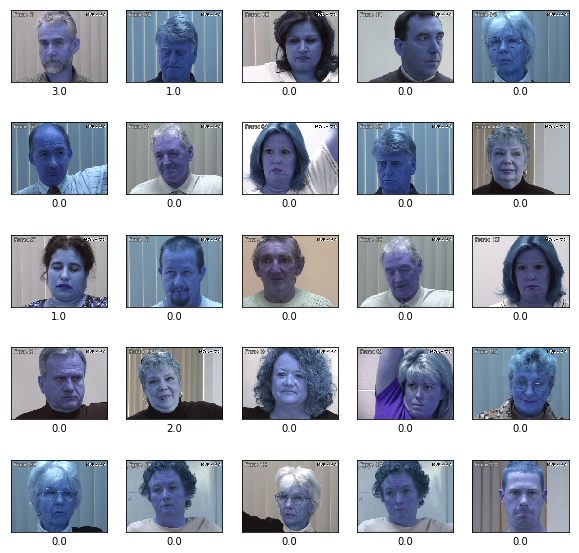

In [3]:
plt.figure(figsize=(10,10))
 
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(final_Array[i], cmap=plt.cm.binary)
    plt.xlabel(final_Labels[i])
plt.show()

# Splitting the Data

In [4]:
test_ratio = 0.3
split_location = int(final_Array.shape[0]*(1-test_ratio))
train_data = final_Array[:split_location]
test_data = final_Array[split_location:]

train_labels = final_Labels[:split_location]
test_labels = final_Labels[split_location:]

print('Train Data\t: {}\nTrain Labels\t: {}\nTest Data\t: {}\nTest Labels\t: {}'
      .format(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape))

Train Data	: (33878, 240, 320, 3)
Train Labels	: (33878,)
Test Data	: (14520, 240, 320, 3)
Test Labels	: (14520,)


In [5]:
train_data = train_data.reshape((33878, 240, 320, 3))
train_data = train_data.astype('float32') / 255

In [6]:
test_data = test_data.reshape((14520, 240, 320, 3))
test_data = test_data.astype('float32') / 255

# Define Functions and Classes

In [7]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [PSPI]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$PSPI^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2)
    #(monitor='val_loss', patience=3)

# Tensorflow Model
### Build

In [8]:
def build_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1280, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1)#(16, activation=tf.nn.softmax)
    ])

#    model.compile(optimizer=tf.train.AdamOptimizer(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    model.compile(optimizer=tf.train.AdamOptimizer(), loss = 'mean_squared_error', metrics = ['mean_absolute_error','mean_squared_error'])
    
    #model.compile(optimizer=tf.keras.optimizers.RMSprop(0.1), 
    #              loss = 'mean_squared_error', 
    #              metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

### Training

In [9]:
model = build_model()

history = model.fit(train_data, 
                    train_labels, 
                    epochs=20, 
                    batch_size=128,
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.

........

### Evaluation

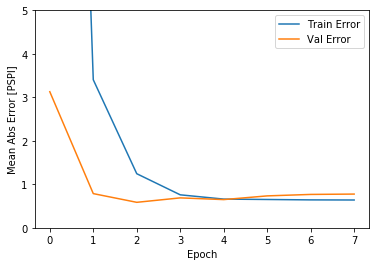

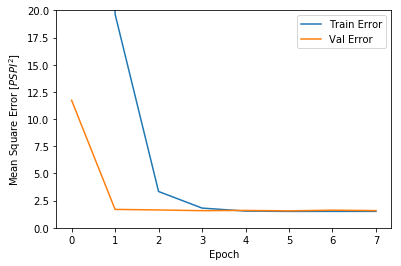

In [10]:
plot_history(history)

In [11]:
model.evaluate(test_data, test_labels)

14520/14520 [==============================] - 11s 760us/sample - loss: 1.5403 - mean_absolute_error: 0.7601 - mean_squared_error: 1.5403


[1.5402853057075794, 0.7600635, 1.540284]

TOP 15 PICTURES OF PEOPLE IN PAIN


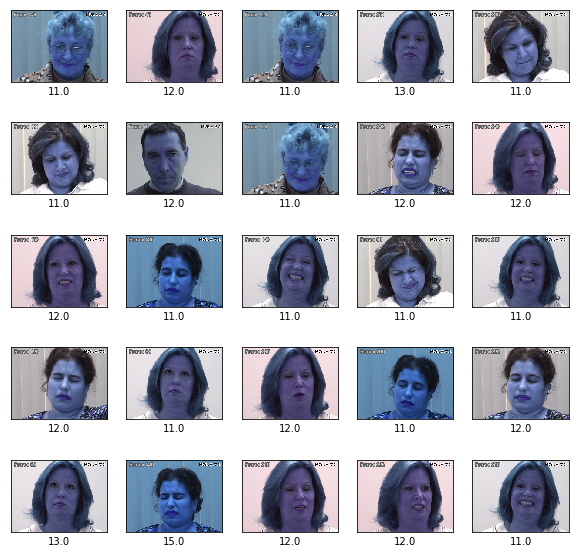

In [77]:
cut = 10
result = np.where(test_labels > cut)

print("TOP 15 PICTURES OF PEOPLE IN PAIN")


plt.figure(figsize=(10,10))
 
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_data[result][i], cmap=plt.cm.binary)
    plt.xlabel(test_labels[result][i])
plt.show()
 
